# Tutorial 2: Pushforward-Based Delay-Coordinate Invariant Measure Optimization for Learning a Neural Network Model of the Lorenz-63 Dynamics

In this tutorial, we use delay-coordinate invariant measures to perform data-driven system identification over a large parameter space. Rather relying on long trajectory simulations for approximation of the delay-coordinate invariant measure, in this tutorial we recast the optimization in terms of pushforward measures which enables us to use gradient based techniques. In particular, we seek to minimize the objective $$\mathcal{J}(\theta) = \mathcal{D}(\mu,T_{\theta}\#\mu)+ \sum_{i=1}^{\ell}\mathcal{D}(\hat{\mu}_{y_{i}},\Psi_{(y_{i},T_{\theta})}),$$ where $y_1,\dots , y_{\ell}$ are scalar valued observables and $T_{\theta}$ is the time-$\Delta t$ flow map of a neural network parameterized velocity.  

We begin by importing the relevant packages.

In [69]:
pip install geomloss

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
from torch import optim
from sklearn.preprocessing import MaxAbsScaler
import random
from geomloss import SamplesLoss


We now simulate a long trajectory of the Lorenz-63 system, which we use as our training data.

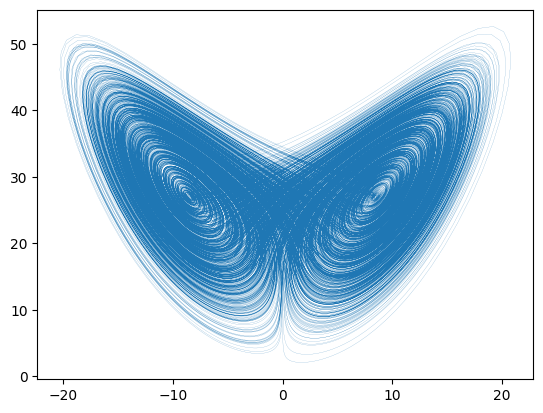

In [71]:
def lorenz(xyz, param):
    s, r, b = 10, 28, param
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])

dt = 0.01
num_steps = int(1e5)
y = np.zeros((num_steps + 1, 3))
y[0] = np.array([-5.065457, -7.56735 , 19.060379])
for i in range(num_steps):
    y[i + 1] = y[i] + lorenz(y[i],8/3) * dt

plt.plot(y[:,0],y[:,2],linewidth = 0.1)
plt.show()


The following function constructs vecor-valued time-delay coordinates corresponding with observables corresponding to each axis projection of a multivariate time-series. We consider an embedding dimension of $m = 5$ and a discrete time-delay of $\overline{\tau} = 10.$

In [72]:
_,dim_state = np.shape(y)
dim_embed = 5
tau = 10

def delay(Y,dim,tau):
    delayed = torch.zeros((dim_state,len(Y)-tau*(dim-1),dim))
    for i in range(dim):
        delayed[:,:,i] = Y[dim*tau-(i+1)*tau:][:len(Y)-tau*(dim-1)].T
    return delayed

We next rescale our data for neural network training.

In [73]:
transformer = MaxAbsScaler().fit(y)
y = transformer.transform(y)
y = torch.tensor(y,dtype = torch.float)

We now construct the delay-coordinate invariant measures $\hat{\mu}_{y_1},\dots, \hat{\mu}_{y_{\ell}}$, which are all contained in **y_delay**,   as well as the measures $\mu$ and $T\#\mu$, which are given by **y** and **Ty_true**, respectively. In this case, $y_i$ is simply the projection onto the $i$-th state-coordinate axis.




In [74]:
y_delay = delay(y,dim_embed,tau)
y = y[:-(dim_embed-1)*tau]
Ty_true = y[tau:]
y = y[:-tau]

We now define our neural network model for the Lorenz-63 system's velocity.

In [75]:
torch.manual_seed(123)
net = nn.Sequential(
    nn.Linear(3, 100),
    nn.Tanh(),
    nn.Linear(100,100),
    nn.Tanh(),
    nn.Linear(100,100),
    nn.Tanh(),
    nn.Linear(100,3))


Next, we use geomloss to define the Energy MMD loss function over the space of probability measures. This will play the role of $\mathcal{D}$ during optimization.

In [76]:
loss = SamplesLoss(loss="energy")

Finally, before training the neural network model we define an optimizer and declare some important training parameters. NSteps is the number of training iterations we will take, lr denotes the learning rate, and num_samples is the number of samples we use at each iteration to approximate the relevant measures.

In [77]:
optimizer = optim.Adam(net.parameters(), lr=1e-3)
Nsteps = 15000
num_samples = 500

We now train the neural network to optimize the loss $\mathcal{J}(\theta) = \mathcal{D}(\mu,T_{\theta}\#\mu)+ \sum_{i=1}^{\ell}\mathcal{D}(\hat{\mu}_{y_{i}},\Psi_{(y_{i},T_{\theta})}).$ We consider first the case when $\ell = 1,$ which is the result we show in the paper, and we also include commented out code which can be used for the case when $\ell = 3$, i.e., when all delay-coordinate invariant measures are incorporated during optimization.

In [78]:
for step in range(Nsteps):

    # STEP 1: Obtain finite-sample approximations to the underlying measures from data.
    batch_ixs = list(range(0,len(y)))
    ixs = random.sample(batch_ixs,num_samples)
    y_batch = torch.tensor(y[ixs] ,requires_grad = True)
    Ty_batch = torch.tensor(Ty_true[ixs],requires_grad = True)
    y_delay_batch = torch.tensor(y_delay[:,ixs,:],requires_grad = True)

    # STEP 2: Zero out gradients of the optimizer.
    optimizer.zero_grad()

    # STEP 3: Use the neural network model of the velocity to approximate the pushforward measures.
    sols = []
    yy = y_batch.clone()
    for j in range(tau*dim_embed):
        sols.append(yy)
        yy = net(yy)*dt+yy
    sol = torch.stack(sols, dim=0)
    Ty = sol[tau,:,:]
    sol = sol.T
    DIM = torch.flip(sol[:,:,::tau],[2])

    # STEP 4: Compute the loss
    L = loss(Ty,Ty_batch) + loss(DIM[0],y_delay_batch[0])
   #L = loss(Ty,Ty_batch) + loss(DIM,y_delay_batch).sum() #uncomment this line to instead use a loss that considers multiple delay-coordinate invariant measures.

    # STEP 5: Compute gradients and update network parameters
    L.backward()
    optimizer.step()

    #plot current progress
    if step%1000 == 0:
        print('iteration : ', step, '| loss :', L.clone().detach().numpy())


<ipython-input-78-961630685>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y[ixs] ,requires_grad = True)
<ipython-input-78-961630685>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Ty_batch = torch.tensor(Ty_true[ixs],requires_grad = True)
<ipython-input-78-961630685>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_delay_batch = torch.tensor(y_delay[:,ixs,:],requires_grad = True)


iteration :  0 | loss : 0.026355624
iteration :  1000 | loss : 0.005028367
iteration :  2000 | loss : 0.0018824935
iteration :  3000 | loss : 0.0015648007
iteration :  4000 | loss : 0.0010485649
iteration :  5000 | loss : 0.00062698126
iteration :  6000 | loss : 0.00037789345
iteration :  7000 | loss : 0.00028437376
iteration :  8000 | loss : 0.00021362305
iteration :  9000 | loss : 0.0001335144
iteration :  10000 | loss : 0.0001437664
iteration :  11000 | loss : 5.7160854e-05
iteration :  12000 | loss : 0.00012218952
iteration :  13000 | loss : 5.6505203e-05
iteration :  14000 | loss : 3.629923e-05


Next, we assess our model performunce by using the learned velocity from the neural network training to plot a long trajectory of the Lorenz-63 system.

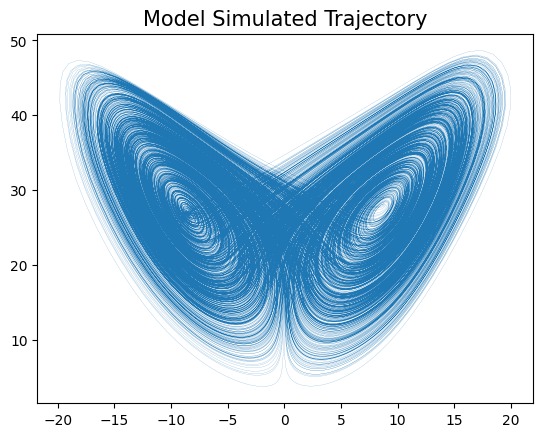

In [81]:
x = y_batch[0]
xs = []
for i in range(int(1e5)):
    xs.append(x.clone().detach().numpy())
    x  = x+dt*net(x)
xs = transformer.inverse_transform(np.array(xs))
plt.title('Model Simulated Trajectory',fontsize = 15)
plt.plot(xs[:,0],xs[:,2],linewidth = .1)
plt.show()


Visually, we have good matching of our neural network model for the velocity with the true attractor of the Lorenz-63 system.

In this tutorial, we showed how to optimize the objective $\mathcal{J}(\theta) = \mathcal{D}(\mu,T_{\theta}\#\mu)+ \sum_{i=1}^{i}\mathcal{D}(\hat{\mu}_{y_{i}},\Psi_{(y_{i},T_{\theta})}),$ for a neural network parameterization of the underlying dynamics. In general, to have a theoretical guarantee for unique identifiability of the dyanmics using delay-coordinate invariant measures, an initial condition must also be incorporated into the optimization. That is, one may instead consider the modified loss $$\mathcal{J}'(\theta) = \mathcal{D}(\mu,T_{\theta}\#\mu)+ \sum_{i=1}^{\ell}\mathcal{D}(\hat{\mu}_{y_{i}},\Psi_{(y_{i},T_{\theta})})+ \frac{1}{\ell m}\sum_{j=1}^\ell\sum_{k=0}^{m-1}\|y_j(t_k;\theta) - y_j(t_k)\|_2^2.$$
For an example where we incorporate this initial condition into the optimization procedure, refer to the file **learn_flow_push.py** in our **Cylinder Flow Example** folder.